<a href="https://colab.research.google.com/github/AedinMcCann/Thesis/blob/main/FINAL_AMD_Rolling_Linear_submissions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Packages

In [27]:
pip install yfinance

In [28]:
pip install yahoofinancials

In [29]:
pip install pyfinance

In [30]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import yfinance as yf
from yahoofinancials import YahooFinancials
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit
import statsmodels.api as sm
import pyfinance
from pyfinance import ols
import pandas_datareader as pdr
import matplotlib.pyplot as plt

# Data

In [31]:
# Get stock data
start='2020-01-01'
end='2021-01-02'
df = yf.download(tickers = "AMD",start=start,end=end,interval = "1d")
df.reset_index(drop=False, inplace=True)

nan_value = float("NaN")
df.replace("", nan_value, inplace=True)
df.tail()
df['Next_close'] = df['Close'].shift(-1)
df.tail()

[*********************100%***********************]  1 of 1 completed


,Date,Open,High,Low,Close,Adj Close,Volume,Next_close
248,2020-12-24,91.800003,92.510002,91.309998,91.809998,91.809998,16705900,91.599998
249,2020-12-28,92.930000,93.139999,90.820000,91.599998,91.599998,30627300,90.620003
250,2020-12-29,91.660004,92.459999,89.430000,90.620003,90.620003,31748200,92.290001
251,2020-12-30,90.779999,92.849998,90.190002,92.290001,92.290001,25845000,91.709999
252,2020-12-31,92.099998,92.300003,90.870003,91.709999,91.709999,24930700,NaN


In [32]:
# Add in some technical indicators
# Simple moving average (SMA)
# 3 day period
Close = df[['Close']]
df['SMA'] = df.Close.rolling(3, min_periods=1).mean()

# Exponential moving average (EMA)
df['EMA'] = df.Close.ewm(alpha=0.1, adjust=False).mean()

In [33]:
# On Balance Volume
# Measures cumulative buying and selling pressure by adding the volume on "up" days and subtracting volume on "down" days. 
df['obv'] = (np.sign(df['Close'].diff()) * df['Volume']).fillna(0).cumsum()
df = df.set_index('Date')
df

,Open,High,Low,Close,Adj Close,Volume,Next_close,SMA,EMA,obv
Date,,,,,,,,,,
2020-01-02,46.860001,49.250000,46.630001,49.099998,49.099998,80331100,48.599998,49.099998,49.099998,0.0
2020-01-03,48.029999,49.389999,47.540001,48.599998,48.599998,73127400,48.389999,48.849998,49.049998,-73127400.0
2020-01-06,48.020000,48.860001,47.860001,48.389999,48.389999,47934900,48.250000,48.696665,48.983999,-121062300.0
2020-01-07,49.349998,49.389999,48.040001,48.250000,48.250000,58061400,47.830002,48.413333,48.910599,-179123700.0
2020-01-08,47.849998,48.299999,47.139999,47.830002,47.830002,53767000,48.970001,48.156667,48.802539,-232890700.0
...,...,...,...,...,...,...,...,...,...,...
2020-12-24,91.800003,92.510002,91.309998,91.809998,91.809998,16705900,91.599998,92.173335,92.234662,342785400.0
2020-12-28,92.930000,93.139999,90.820000,91.599998,91.599998,30627300,90.620003,91.653333,92.171196,312158100.0
2020-12-29,91.660004,92.459999,89.430000,90.620003,90.620003,31748200,92.290001,91.343333,92.016077,280409900.0


In [34]:
df = df[['Next_close', 'Close','Volume','Open','High','Low', "SMA", 'EMA', 'obv']]

In [35]:
dataset = df.values
scaler = MinMaxScaler()
# transform data
dataset = scaler.fit_transform(dataset)

X = dataset[:-1,1:]
y = dataset[:-1, 0]
x = pd.DataFrame(X)
y = pd.DataFrame(y)

In [36]:
rolling = ols.PandasRollingOLS(y=y, x=X, window=20)
y_pred = rolling.predicted
y_pred = pd.DataFrame(y_pred)
y_pred

predicted
end subperiod           
19  0           0.173209
    1           0.168270
    2           0.167744
    3           0.153707
    4           0.177966
...                  ...
251 247         0.899758
    248         0.912298
    249         0.914650
    250         0.897073
    251         0.927877

[4660 rows x 1 columns]

In [37]:
y_pred = y_pred.reset_index()
counts= y_pred['subperiod'].value_counts()
y_pred = y_pred.groupby('subperiod').sum('predicted')
y_pred['predicted'] = y_pred['predicted']/counts
y_pred = y_pred.reset_index()
y_pred = y_pred.drop(['end'], axis=1)
y_pred

,subperiod,predicted
0,0,0.173209
1,1,0.175629
2,2,0.178156
3,3,0.161159
4,4,0.163983
...,...,...
247,247,0.908172
248,248,0.918760
249,249,0.918823
250,250,0.902101


In [38]:
df_y = y.reset_index()
df_y = df_y.rename(columns={'index':'period', 0:'actual'})
df_y

,period,actual
0,0,0.169320
1,1,0.165725
2,2,0.163328
3,3,0.156138
4,4,0.175655
...,...,...
247,247,0.909091
248,248,0.905496
249,249,0.888718
250,250,0.917309


In [39]:
linear = df_y.join(y_pred, how='outer')
linear['difference'] = linear['actual'] - linear['predicted']
linear = linear.drop(['period','subperiod'], axis=1)
linear['sq_er'] = linear['difference']*linear['difference']
linear['AMD_RMSE_LIN'] = np.sqrt(linear['sq_er'])
linear

,actual,predicted,difference,sq_er,AMD_RMSE_LIN
0,0.169320,0.173209,-0.003888,1.511851e-05,0.003888
1,0.165725,0.175629,-0.009904,9.807996e-05,0.009904
2,0.163328,0.178156,-0.014828,2.198703e-04,0.014828
3,0.156138,0.161159,-0.005021,2.521213e-05,0.005021
4,0.175655,0.163983,0.011672,1.362341e-04,0.011672
...,...,...,...,...,...
247,0.909091,0.908172,0.000919,8.440358e-07,0.000919
248,0.905496,0.918760,-0.013264,1.759453e-04,0.013264
249,0.888718,0.918823,-0.030105,9.063393e-04,0.030105
250,0.917309,0.902101,0.015207,2.312608e-04,0.015207


In [40]:
MSE = linear['sq_er'].sum()/len(linear)
import math 
RMSE = math.sqrt(MSE)
RMSE

0.0222160125115071

# With sentiment

In [41]:
sent = pd.read_csv('AMD_sentiment_submissions.csv')
sent = sent.rename(columns={'date':'Date'})
sent['Date'] = pd.to_datetime(sent['Date'])
df = pd.merge(df, sent, on = 'Date', how = 'left')
df = df.fillna(0)
df.describe()

,Next_close,Close,Volume,Open,High,Low,SMA,EMA,obv,Unnamed: 0,compound,Count,average
count,253.000000,253.000000,2.530000e+02,253.000000,253.000000,253.000000,253.000000,253.000000,2.530000e+02,253.000000,253.000000,253.000000,253.000000
mean,65.425652,65.619723,6.157304e+07,65.599091,66.924032,64.169328,65.450211,64.093276,2.691104e+08,136.494071,1.208534,7.229249,0.171319
std,17.574979,17.114718,2.622680e+07,17.166342,17.253292,16.925008,17.000932,15.919117,1.864866e+08,98.613025,2.202494,8.194245,0.313050
min,0.000000,38.709999,1.670590e+07,39.080002,41.700001,36.750000,39.516666,43.807664,-2.328907e+08,0.000000,-5.865300,0.000000,-0.855500
25%,51.709999,51.709999,4.304570e+07,51.340000,52.299999,49.900002,51.416667,50.377889,1.471359e+08,44.000000,0.000000,2.000000,0.000000
50%,56.389999,56.389999,5.396170e+07,56.650002,57.580002,54.840000,55.576667,53.956425,2.815788e+08,134.000000,0.692800,5.000000,0.133285
75%,82.239998,82.239998,7.651280e+07,82.550003,83.959999,80.879997,82.243332,80.819378,4.154344e+08,222.000000,2.277500,10.000000,0.342856
max,97.120003,97.120003,2.053145e+08,97.550003,97.980003,96.250000,96.936666,92.363163,6.787023e+08,311.000000,12.176600,52.000000,0.999433


In [42]:
df = df[['Next_close', 'Close','Volume','Open','High','Low', "SMA", 'EMA', 'obv', 'average']]

dataset = df.values

scaler = MinMaxScaler()
# transform data
dataset = scaler.fit_transform(dataset)

X = dataset[:-1,1:]
x = pd.DataFrame(X)
rolling = ols.PandasRollingOLS(y=y, x=X, window=20)
y_pred_sent = rolling.predicted
y_pred_sent = pd.DataFrame(y_pred_sent)
y_pred_sent = y_pred_sent.reset_index()
y_pred_sent = y_pred_sent.drop(['end'], axis=1)

In [43]:
y_pred_sent = y_pred_sent.reset_index()
counts= y_pred_sent['subperiod'].value_counts()
y_pred_sent = y_pred_sent.groupby('subperiod').sum('predicted')
y_pred_sent['predicted_sent'] = y_pred_sent['predicted']/counts

In [44]:
linear_sent = df_y.join(y_pred_sent, how='outer')
linear_sent = linear_sent.rename(columns = {0:'actual'})

In [45]:
linear_sent['difference_sent'] = linear_sent['actual'] - linear_sent['predicted_sent']
linear_sent = linear_sent.drop(['predicted'], axis=1)
linear_sent['sq_er_sent'] = linear_sent['difference_sent']*linear_sent['difference_sent']
linear_sent['AMD_RMSE_LIN_SENTIMENT'] = np.sqrt(linear_sent['sq_er_sent'])

In [46]:
MSE_sent = linear_sent['sq_er_sent'].sum()/len(linear_sent)
RMSE_sent = math.sqrt(MSE_sent)
RMSE_sent

0.023502118894132878

In [47]:
AMD_linear = pd.merge(linear, linear_sent, on = 'actual')
AMD_linear

,actual,predicted,difference,sq_er,AMD_RMSE_LIN,period,index,predicted_sent,difference_sent,sq_er_sent,AMD_RMSE_LIN_SENTIMENT
0,0.169320,0.173209,-0.003888,1.511851e-05,0.003888,0,0,0.173296,-0.003976,1.580813e-05,0.003976
1,0.165725,0.175629,-0.009904,9.807996e-05,0.009904,1,21,0.176129,-0.010404,1.082332e-04,0.010404
2,0.163328,0.178156,-0.014828,2.198703e-04,0.014828,2,63,0.177837,-0.014509,2.105012e-04,0.014509
3,0.156138,0.161159,-0.005021,2.521213e-05,0.005021,3,126,0.159184,-0.003046,9.279011e-06,0.003046
4,0.175655,0.163983,0.011672,1.362341e-04,0.011672,4,210,0.160567,0.015088,2.276548e-04,0.015088
...,...,...,...,...,...,...,...,...,...,...,...
265,0.909091,0.908172,0.000919,8.440358e-07,0.000919,247,23085,0.909866,-0.000776,6.016500e-07,0.000776
266,0.905496,0.918760,-0.013264,1.759453e-04,0.013264,248,18510,0.918169,-0.012673,1.606137e-04,0.012673
267,0.888718,0.918823,-0.030105,9.063393e-04,0.030105,249,13914,0.917413,-0.028695,8.234207e-04,0.028695
268,0.917309,0.902101,0.015207,2.312608e-04,0.015207,250,9297,0.903015,0.014294,2.043138e-04,0.014294


In [48]:
AMD_linear.describe()

,actual,predicted,difference,sq_er,AMD_RMSE_LIN,period,index,predicted_sent,difference_sent,sq_er_sent,AMD_RMSE_LIN_SENTIMENT
count,270.000000,270.000000,270.000000,2.700000e+02,270.000000,270.000000,270.000000,270.000000,270.000000,2.700000e+02,270.000000
mean,0.462648,0.462927,-0.000279,4.989529e-04,0.017047,125.744444,43409.222222,0.460257,0.002391,5.544604e-04,0.017466
std,0.291944,0.290935,0.022377,7.857669e-04,0.014461,72.227577,26544.075510,0.291945,0.023469,1.137632e-03,0.015822
min,0.000000,0.026215,-0.056499,2.816937e-09,0.000053,0.000000,0.000000,0.020000,-0.056275,3.657746e-09,0.000060
25%,0.227572,0.231344,-0.013169,4.014846e-05,0.006336,64.250000,20490.000000,0.225880,-0.011797,4.492801e-05,0.006703
50%,0.302688,0.290408,-0.001070,1.536791e-04,0.012396,124.500000,42990.000000,0.281877,0.000773,1.658258e-04,0.012877
75%,0.749872,0.758919,0.012298,7.114211e-04,0.026665,187.750000,65890.000000,0.756252,0.013638,6.734051e-04,0.025949
max,1.000000,0.996578,0.079643,6.342940e-03,0.079643,251.000000,89190.000000,0.996624,0.112705,1.270252e-02,0.112705


Text(0.5, 0.98, 'Root Mean Squared Error Distribution With Sentiment')

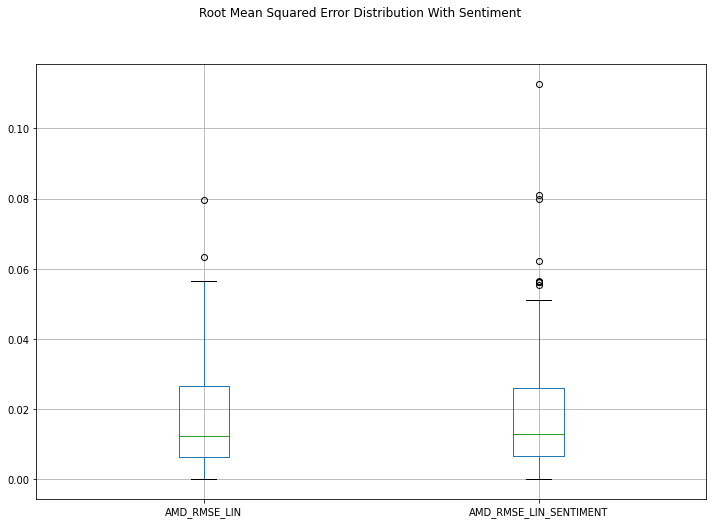

In [49]:
boxplot = AMD_linear.boxplot(column=['AMD_RMSE_LIN', 'AMD_RMSE_LIN_SENTIMENT'],figsize=(12,8))
[ax_tmp.set_xlabel('') for ax_tmp in np.asarray(boxplot).reshape(-1)]
fig = np.asarray(boxplot).reshape(-1)[0].get_figure()
fig.suptitle('Root Mean Squared Error Distribution With Sentiment')

In [50]:
AMD_linear_RMSE = AMD_linear[['AMD_RMSE_LIN', 'AMD_RMSE_LIN_SENTIMENT']]
AMD_linear_RMSE.describe()

,AMD_RMSE_LIN,AMD_RMSE_LIN_SENTIMENT
count,270.000000,270.000000
mean,0.017047,0.017466
std,0.014461,0.015822
min,0.000053,0.000060
25%,0.006336,0.006703
50%,0.012396,0.012877
75%,0.026665,0.025949
max,0.079643,0.112705


In [51]:
AMD_linear_RMSE.to_csv('AMD_Linear_Subs_Results.csv')